In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib




# Ephaptic Coupling #

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
from os.path import join
import LFPy
import neuron
from neuron import h

## Fetch model files
### Cell type and cell parameters ###

In [3]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5.hoc',
    'passive' : False, # turn on NEURONs passive mechanism for all sections
    'nsegs_method' : None,
    'dt' : 2**-6,   # simulation time step size
    'tstart' : 0,  # start time of simulation, recorders start at t=0
    'tstop' : 30, # stop simulation at 100 ms.
    'v_init' : -60, # initial crossmembrane potential
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
    'cm' : 1.0,         # membrane capacitance
    'Ra' : 150.,        # axial resistance
}


### Creating generator_cell

In [4]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.Cell(**cellParameters)
# Align cell
generator_cell.set_rotation(x=4.99, y=-4.33, z=0)

### Puting Synapse ###

In [5]:
synapse = LFPy.Synapse(generator_cell, 
                       idx = generator_cell.get_idx("soma[0]"), #cell.get_closest_idx(x=0., y=0., z=100.),
                       syntype = 'Exp2Syn', 
                       weight = 0.005, 
                       e = 0, 
                       tau1 = 0.5,
                       tau2 = 2,
                       record_current = True)
synapse.set_spike_times(np.array([2.,8]))

### Measuring the external field in the positions of receptor_cell

In [6]:
# place electrodes at each segment of the cell
# define parameters for extracellular recording electrode, using optional method
# x,y,z are coordinates of contacts (from the grid in xz-plane over which we calculate local field potentials)
electrodeParameters = {
    'sigma' : 0.3,                  # extracellular conductivity
    'x' : generator_cell.xmid,      # + distance of the electrodes to the receptor cell
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

# create extracellular electrode object for LFPs on grid
#receptor_electrode = LFPy.RecExtElectrode(**electrodeParameters)

# perform NEURON simulation of the generator cell
# results saved as attributes in the cell instance
#generator_cell.simulate(electrode = receptor_electrode,rec_imem=True)

# Calculate LFPs
#receptor_electrode.calc_lfp()

### Creating grid electrode (for Contour plot) and point electrode (for simple plots)

In [7]:
# Create a grid of measurement locations, in (mum)
X, Z = np.mgrid[-700:701:50, -400:1201:50]
Y = np.zeros(X.shape)

# Define electrode parameters
grid_electrode_parameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

# Define electrode parameters
point_electrode_parameters = {
    'sigma' : 0.3,  # extracellular conductivity
    'x' : np.array([130., 220.]), #positions of the first(blue) and second(green) electrode
    'y' : np.array([   0.,    0.]),
    'z' : np.array([   0.,  700.]),
}

# Run simulation, electrode object argument in cell.simulate
generator_cell.simulate(rec_imem=True)

# Create electrode objects
grid_electrode = LFPy.RecExtElectrode(generator_cell,**grid_electrode_parameters)
point_electrode = LFPy.RecExtElectrode(generator_cell,**point_electrode_parameters)

# Calculate LFPs
grid_electrode.calc_lfp()
point_electrode.calc_lfp()

### Ploting Generator and Receptor cell morphologies

/home/renata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


[]

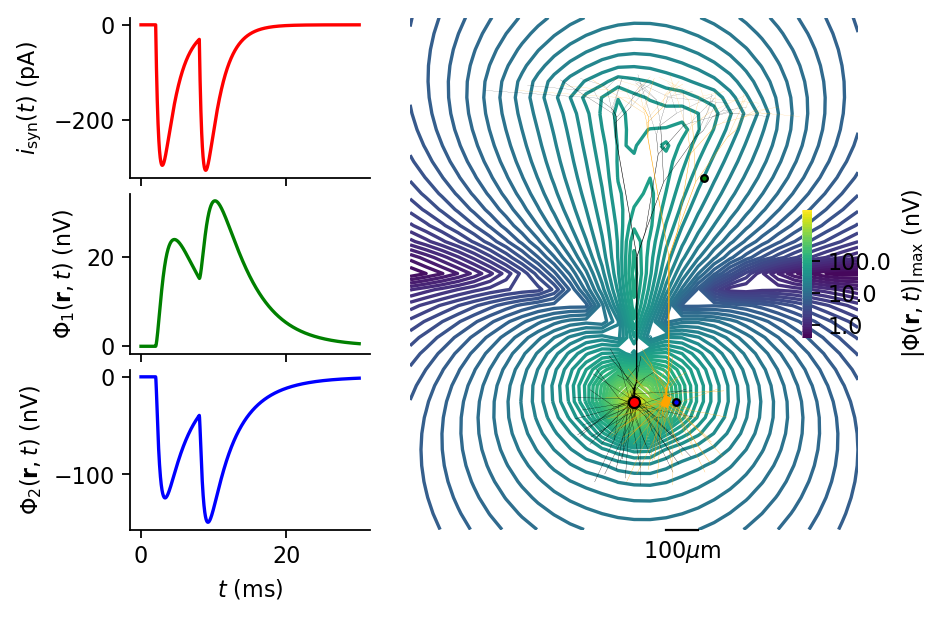

In [8]:
fig = plt.figure(dpi=160)

ax = fig.add_axes([.4,.1,.55,.8], aspect='equal', frameon=False)
cax = fig.add_axes([0.85, 0.4, 0.01, 0.2], frameon=False)

LFP = np.max(np.abs(grid_electrode.LFP),1).reshape(X.shape)
im = ax.contour(X, Z, np.log10(LFP), 
            50,
           cmap='viridis', #'viridis', 'plasma', 'inferno', 'magma', 'cividis' https://matplotlib.org/tutorials/colors/colormaps.html#mycarta-banding
           zorder=-2)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)')
cbar.outline.set_visible(False)

#get some log-linear tickmarks and ticklabels
ticks = np.arange(np.ceil(np.log10(LFP.min())), np.floor(np.log10(LFP.max())))
cbar.set_ticks(ticks)
cbar.set_ticklabels(np.round(10.**ticks * 1E6, decimals=1)) #mV -> nV

#plot morphology of generator_cell
zips = []
for x, z in generator_cell.get_idx_polygons():
    zips.append(list(zip(x, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors='k')
ax.add_collection(polycol)

#plot morphology of receptor_cell
shift = 100 #shift of receptor_cell in x dimension
zips = []
for x, z in generator_cell.get_idx_polygons():
    zips.append(list(zip(x+shift, z)))
polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors= 'orange')
ax.add_collection(polycol)

ax.plot([100, 200], [-400, -400], 'k', lw=1, clip_on=False)
ax.text(150, -470, r'100$\mu$m', va='center', ha='center')

ax.axis('off')

#Plot points where the synapse is
ax.plot(generator_cell.xmid[generator_cell.synidx],generator_cell.zmid[generator_cell.synidx], 'o', ms=5,
        markeredgecolor='k',
        markerfacecolor='r')

#Plot points where the LFP is been recorded
color_vec = ['blue','green']
for i in range(2):
    ax.plot(point_electrode_parameters['x'][i],
                    point_electrode_parameters['z'][i],'o',ms=3,
                    markeredgecolor='k',
                    markerfacecolor=color_vec[i])
    
#Plot LFP blue electrode [0]
plt.axes([.15,.10,.25,.25])
plt.plot(generator_cell.tvec,point_electrode.LFP[0]*1e6,color=color_vec[0], clip_on=False)
plt.ylabel(r'$\Phi_2(\mathbf{r},t)$ (nV)')
plt.xlabel(r'$t$ (ms)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

#Plot LFP green electrode
plt.axes([.15,.375,.25,.25])
plt.plot(generator_cell.tvec,point_electrode.LFP[1]*1e6,color=color_vec[1], clip_on=False)
plt.ylabel(r'$\Phi_1(\mathbf{r}, t)$ (nV)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

#Plot synapse electrode
plt.axes([.15,.65,.25,.25])
plt.plot(generator_cell.tvec,synapse.i*1E3, color='red', clip_on=False)
plt.ylabel(r'$i_\mathrm{syn}(t)$ (pA)')
plt.axis('tight')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

# Optionally save figure (uncomment the line below)
# plt.savefig('LFPy-example-3.pdf', dpi=300)